In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Remember that in week 1 we had generated open-loop commands for a set of manoeuvres such as
$[("straight", 5), ("right", 90), ("straight", 6), ("left", 90)]$

Let us do repeat, but with a change. Instead of left/ right, simply use turn and a signed angle.
$[("straight", 5), ("turn", -90), ("straight", 6), ("turn", 90)]$

You can use cubic_spiral() from previous notebook

In [2]:
def cubic_spiral(theta_i, theta_f, n=10):
    x = np.linspace(0, 1, num=n)
    #-2*x**3 + 3*x**2
    return (theta_f-theta_i)*(-2*x**3 + 3*x**2) + theta_i

In [3]:
v = 1
dt = 0.1
num_st_pts = int(v/dt)
num_pts = 50

def straight(dist, curr_pose, n=num_st_pts):
    # the straight-line may be along x or y axis
    #curr_theta will determine the orientation
    x0, y0, t0 = curr_pose
    xf, yf = x0 + dist*np.cos(t0), y0 + dist*np.sin(t0)
    x = (xf-x0)*np.linspace(0,1,n)+x0
    y = (yf-y0)*np.linspace(0,1,n)+y0
    return x, y, t0*np.ones_like(x)

def turn(change, curr_pose, n=num_pts):
    # adjust scaling constant for desired turn radius
    x0, y0, t0 = curr_pose
    theta = cubic_spiral(t0, t0 + np.deg2rad(change), n)
    x = x0 + np.cumsum(v*np.cos(theta)*dt)
    y = y0 + np.cumsum(v*np.sin(theta)*dt)
    return x, y, theta

def generate_trajectory(route, init_pose = (0, 0,np.pi/2)):
    curr_pose = init_pose
    func = {'straight': straight, 'turn': turn}
    x, y, t = np.array([]), np.array([]),np.array([])
    for manoeuvre, command in route:
        px, py, pt = func[manoeuvre](command, curr_pose)
        curr_pose = px[-1],py[-1],pt[-1]
        # update x, y, t using np.concatenate and px,py,pt
        x, y, t = np.concatenate([x,px]), np.concatenate([y,py]), np.concatenate([t,pt])
    return x, y, t

### Plot the trajectory
plot the trajectory and the change in orientation in separate plots

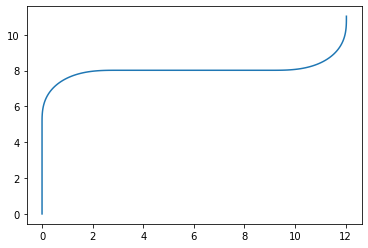

In [4]:
route = [("straight",5),("turn", -90),("straight",6),("turn",90)]
x, y, t = generate_trajectory(route)
plt.figure()
plt.plot(x,y)

## Convert 

A* or Djikstra gives a sequence of $\{(x_i, y_i)\}$. We need to convert it to a sequence of {"straight", "turn"} if we are use generate_trajectory()

Let us look at a simple method. Assume that the successive line segments are orthogonal (reasonable in the grid world). If we find the corner point, we can demarcate. 

For 3 consecutive points $(x_1,y_1), (x_2, y_2), (x_3, y_3)$ if 
$(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) \neq 0$, then $(x_2, y_2)$ is a corner point

Think about what is happening if

1. $(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) > 0$

2. $(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) < 0$

In [5]:
def euclidean(pose2, pose1):
  return(((pose2[0]-pose1[0])**2 + (pose2[1]-pose1[1])**2)**0.5)

[(0, 5)]


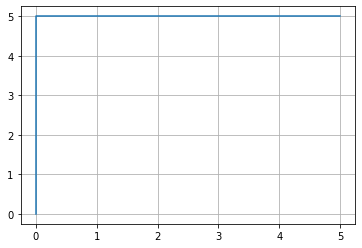

In [6]:
# here is a code to generate 2 orthogonal 
# line segments of lengths 6

s1, s2 = 6, 6
y1 = list(range(s1))
x1 = [0]*s1

x2 = list(range(s2))
y2 = [y1[-1]]*s2

x, y = x1[:-1]+x2, y1[:-1]+y2
plt.figure()
plt.plot(x, y)
plt.grid()

#find the corner point and plot it
corners=[]
for i in range(len(x)-2):
    if abs((x[i+1]-x[i])*(y[i+2]-y[i+1])-(x[i+2]-x[i+1])*(y[i+1]-y[i])) > 0.0:
        corners.append((x[i+1], y[i+1]))
print(corners)

# Fix a turn radius r
# Shorten the straight segments by r
# convert this into {("straight", s1), ("turn", +/- 90), ("straight", s2)}
commands = []
i, cor=0, -1
while i <len(x)-2:
    x1,y1 = x[i],y[i]
    x2,y2 = x[i+1],y[i+1]
    x3,y3 = x[i+2],y[i+2]
    eval = cor*((x1-x2)*(y3-y2)-(x3-x2)*(y2-y1))
    if eval != 0:
        i+=1
        cor*=-1
        if eval >0:
            commands.append(("turn",-90))
        else:
            commands.append(("turn",90))
    else:
        commands.append(("straight",euclidean( (x2,y2), (x1,y1)) ))
    i+=1

# use generate_trajectory() and plot the smooth path

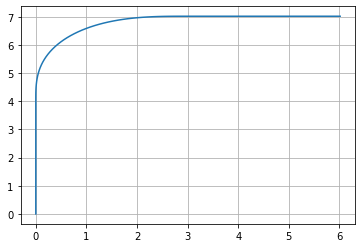

In [7]:
x,y,t = generate_trajectory(commands)
plt.figure()
plt.plot(x, y)
plt.grid()

# More complex example
Borrow the Grid world code from week 2 notebook. Get the A* path and smoothen it using the routine from above

This approach of path planning with 90 deg turns juxtaposed between straight segments works well in structured environments.

In the general case, where $A^*$/ $RRT^*$ path is a sequence of piecewise linear segments, we will perform a path optimization routine directly. 

There are 3 more advanced manouevres that you may need

1. Lane-change: Robot has to move laterally but without change to the orientation

2. Inplace: Robot has to turn around itself
    
3. Reverse: Straights or turns in reverse

Lane-change has to be applied as a combination of 2 cubic spirals (90 to 0 and 0 to 90). Inplace and Reverse are situational constructs